### This project focuses on computer vision as a topic and the main objective is to classify satellite imagery using neural network models. Dataset is retrieved from Kaggle

#### The first step is to install all needed libraries and import any dependencies

In [1]:
!pip install tensorflow

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import classification_report
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix

#### As precaution, I implemented the code below to ensures that TensorFlow allocates GPU memory only as needed rather than preallocating the entire memory at once.This can be beneficial, especially when dealing with large models or multiple models simultaneously, as it allows TensorFlow to manage GPU memory more efficiently and potentially avoid running out of memory errors.

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Inspect Data

#### It is important to identify which directory I am in inorder to correctly find where I stored the dataset I will be working with from my local computer.

In [5]:
%pwd

'/Users/nahomtamene'

In [6]:
for dirname, _, filenames in os.walk('/Users/nahomtamene/Downloads/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/Users/nahomtamene/Downloads/data/.DS_Store
/Users/nahomtamene/Downloads/data/Final_Project.ipynb
/Users/nahomtamene/Downloads/data/cloudy/train_17406.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_23953.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_34585.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_16042.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_18084.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_34208.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_4641.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_4127.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_4133.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_31358.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_17610.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_827.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_16240.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_35499.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_31600.jpg
/Users/nahomtamene/Downloads/data/cloudy/train_10816

#### This is to see that I can retrieve images to display on my notebook

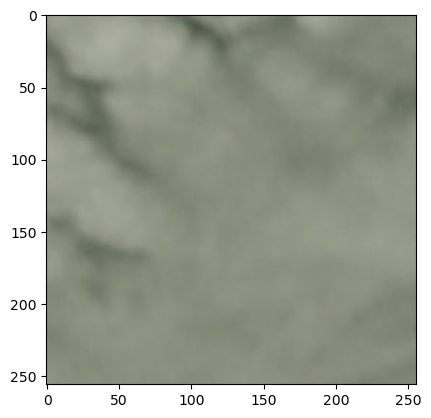

In [7]:
image = plt.imread('/Users/nahomtamene/Downloads/data/cloudy/train_39361.jpg')
plt.imshow(image)

In [8]:
directory=r"/Users/nahomtamene/Downloads/data/"

## EDA preprocessing

### Prepare Data

#### I had a large dataset with over 5000 images and while that is a good amount for training and testing, it also comes with some limitations such as bad data and corrupt images. To check if I had bad data, I implemented the code below to get rid of any files that may appear that way. Fortunately, I didn't have any so I was able to continue with my prject without removing any data.

In [9]:
image = []
label = []
img_width = 32
img_height = 32

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):  # Check if the file is a JPG or JPEG image
            img_path = os.path.join(dirname, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            label.append(os.path.basename(dirname))
            image.append(img)
        else:
            print(f"Ignored file: {filename} (not a JPG or JPEG)")


Ignored file: .DS_Store (not a JPG or JPEG)
Ignored file: Final_Project.ipynb (not a JPG or JPEG)
Ignored file: Final_Project-checkpoint.ipynb (not a JPG or JPEG)


#### To visualize the number of images I had in the dataset:

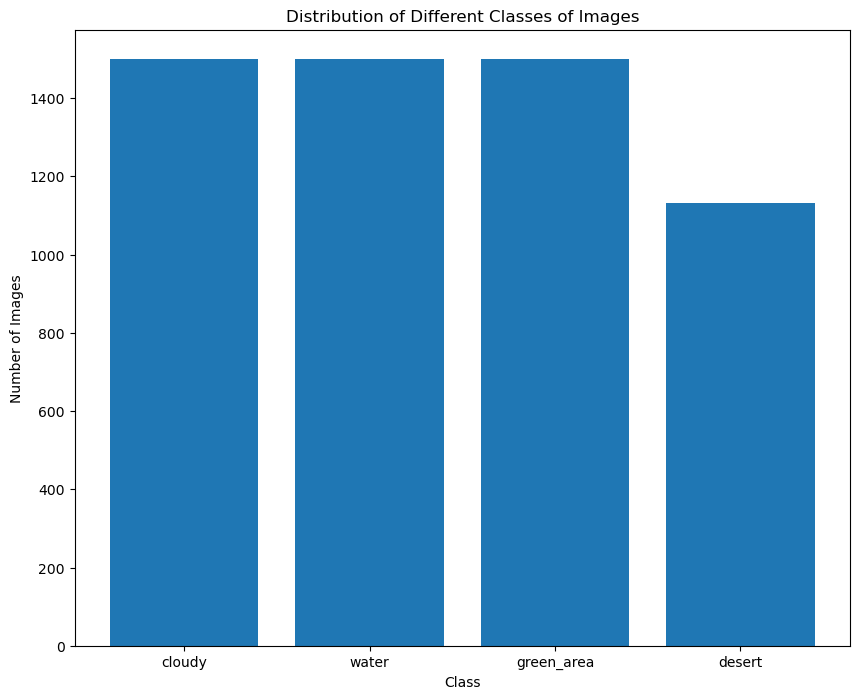

In [10]:
image_classes = ['cloudy', 'water', 'green_area', 'desert']
class_counts = {}

for image_class in image_classes:
    class_path = directory + image_class
    num_images = len(os.listdir(class_path))
    class_counts[image_class] = num_images

# Plot the distribution of images across classes
plt.figure(figsize=(10, 8))
plt.bar(range(len(class_counts)), list(class_counts.values()), align='center')
plt.xticks(range(len(class_counts)), list(class_counts.keys()))
plt.title('Distribution of Different Classes of Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

#### As the count below can show, there is some imbalance within the dataset but I didnt implement features since it wasnt a large ratio

In [11]:
# Count images in each class
for image_class in image_classes:
  class_path = os.path.join(directory, image_class) 
  class_counts[image_class] = 0 

  for filename in os.listdir(class_path):
    if os.path.isfile(os.path.join(class_path, filename)): 
      class_counts[image_class] += 1 

for class_name, count in class_counts.items():
  print(f"Class: {class_name}, Count: {count}")


Class: cloudy, Count: 1500
Class: water, Count: 1500
Class: green_area, Count: 1500
Class: desert, Count: 1131


#### This is where I set up data generators for image data to be used in the CNN model. In this snippet, the images are being loaded and preprocessed. I implemented Data Augmentation through changing the imaging as well as shuffling before it set into a batch inorder to enhance the models generalization and avoid overfitting. I used a 20% split so the  training data can be used for validation.

##### Overall: this prepares the image data for training the model. It defines the image size, performs data augmentation for training data, and splits the data into training and validation sets. It also generates batches of images and labels for both training and validation.

In [12]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32
import os

# Get the list of classes (subdirectories) in the directory
classes = ['cloudy', 'water', 'green_area', 'desert']


# Now create the ImageDataGenerator with the filtered list of classes
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, #Normalizing pixel value
                                                                 zoom_range=0.2,
                                                                 width_shift_range=0.2,
                                                                 height_shift_range=0.2,
                                                                 fill_mode='nearest',
                                                                 validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   classes=classes)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(directory,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True,
                                                             classes=classes)

Found 5631 images belonging to 4 classes.
Found 5631 images belonging to 4 classes.


In [13]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(directory,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical',
                                                 classes=classes)

Found 5631 images belonging to 4 classes.


## Model

#### I defined the Convolutional Neural Network model  using Keras' Sequential API. I initiated 3 convolutional layers each with different hyper parameters. I applied L2 regularization to the weights of the kernel, which helps prevent overfitting

##### Overall: this defines a CNN model that takes in an image, extracts features using convolutional layers, performs downsampling, regularization and normalization, and uses fully-connected layers with ReLU activation and dropout for classification. 

In [14]:
model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', 
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        # Conv2D(filters=64, kernel_size=(3, 3), padding='valid', 
        # kernel_regularizer=l2(0.00005)),#L2 Regularization
        # Activation('relu'),
        # MaxPooling2D(pool_size=(2, 2)),
        # BatchNormalization(),
        
        # Conv2D(filters=32, kernel_size=(3, 3), padding='valid', 
        # kernel_regularizer=l2(0.00005)),
        # Activation('relu'),
        # MaxPooling2D(pool_size=(2, 2)),
        # BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=4, activation='softmax')
    ])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


#### Properties of the model being used:

In [15]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 146, 146, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 682112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   174,620,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,632,196 (666.17 MB)

 Trainable params: 174,631,940 (666.17 MB)

 Non-trainable params: 256 (1.00 KB)

None


#### I am using a library from keras called ReduceLROnPlateau to prevent overfitting and improve training efficiency and create an instance of the optimizer with a learning rate. Then I fit the model with the data I have prepared earlier

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[reduce_lr])

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 128s 717ms/step - accuracy: 0.7494 - loss: 7.2724 - val_accuracy: 0.4933 - val_loss: 2.0685 - learning_rate: 1.0000e-04
Epoch 2/10
131/176 ━━━━━━━━━━━━━━━━━━━━ 27s 612ms/step - accuracy: 0.8661 - loss: 0.5322

In [ ]:
predictions = model.predict(test_generator)

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [ ]:
class_labels = list(validation_generator.class_indices.keys())

## Performance metric

#### Bar Chart showing the accuracy and loss between the training and validation values

In [ ]:
# Access training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Here I calculated the precision, recall and f1-score values of the model to get a better understanding of how it's performing. 

In [ ]:
print(classification_report(y_true, y_pred, target_names=['cloudy', 'water', 'green_area', 'desert']))

#### Another great way to visualize perfomance is through the confusion matrix, it gives us the predictions of the model against the true class labels for a set of test data.

In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()
